---
<div align="center">
    
# S&P-500 | Stock Forecasting and Optimization
</div>

---

---
<div align="center">
    
## Problem Formulation [TO BE FIXED LATER]
</div>

---

### Context

The stock market is highly volatile and unpredictable which makes stock price forecasting and portfolio optimization challenging tasks. Therefore, since investors seek strategies that can provide risk-adjusted returns efficiently, this project aims to help them.

### Resolution Approach

This project focuses on using machine learning algorithms to forecast future stock prices of the S&P-500 Market Index and thereafter apply optimization methods to select the best set of stocks for daily investment. 

It combines data-driven forecasts with optimization techniques to maximize returns or minimize risks, creating a solution for real-world financial challenges.

### Planned Work

To properly develop this project, we have structured it along the following phases:
1. Data Preprocessing & Engineering
2. Data Cleaning
3. Exploratory Data Analysis - We aim to obtain greater insights on how the data 
4. Model Development and Evaluation - Use models like LSTMs, LGBM, Using proper training methodologies [Use a Window and simply move it N days further at each iteration and consider the new window as the training data of the model until we have reached the end of the data, aka, 2024 ]. Note: Always test with the 2024 data.
6. Portfolio Optimization - Using Monte Carlo, Min-Max and even genetic Algorithms
7. Results Analysis

---
<div align="center">
    
## Project Dependencies

</div>

---

In [1]:
# !pip install requests-cache requests-ratelimiter
# !pip install --upgrade yfinance
# !pip install PyPortfolioOpt

In [2]:
# !pip install scikit-learn==0.21.3
# !pip install Cython
# !pip install fbprophet
# !conda install -c anaconda ephem -y
# !conda install -c conda-forge pystan -y
# !conda install -c conda-forge fbprophet -y
# !pip install holidays==0.9.12

# !pip install pystan==2.19.1.1 prophet
# !pip install cmdstanpy==0.9.5

# !pip install fbprophet==0.6
# !pip install holidays==0.9.11

# !pip install lightgbm 

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Importing Dependencies
import numpy as np
import pandas as pd

# Import json to help save dictionaries into .json files
import json

# Import matplotlib to help visualize the data
import matplotlib.pyplot as plt

# Import Datetime to properly format the Dates from the Dataset
from datetime import (datetime, timedelta)
from datetime import datetime as dt

# Importing an API to handle the Datset from Yahoo Finance
import yfinance as yf
from yfinance import (Ticker)

# Import a Sequential Model from tensorflow alongside the Adam Optimizer and layers
from tensorflow.keras.models import (Sequential)
from tensorflow.keras.optimizers import (Adam)
from tensorflow.keras import (layers)

from DataPreProcessing.DataExtraction import (extractSP500StocksInformationWikipedia, getSP500StockMarketInformation, getStockMarketInformation, mergeStocksClosingPrices, selectStocksToUse)
from DataPreProcessing.DataVisualization import (plotFeatureDistribution, plotStockClosingPrice, plotStockStats)

from ModelDevelopmentAndEvaluation.StockPriceManager import (stockPriceManager)
from ModelDevelopmentAndEvaluation.StockPricePredictor import (StockPricePredictor)

from Utils.Configuration import (loadConfig, loadInitialPathsConfig, loadFinalPathsConfig, loadInitialSetup)

# from pprint import pprint

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


In [1]:
from tensorflow.python.client import device_lib

# List all available devices
print("Available devices:")
print(device_lib.list_local_devices())


Available devices:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8139400280423093107
xla_global_id: -1
]


In [2]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if TensorFlow can access GPUs
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
    print("GPU devices:", tf.config.list_physical_devices('GPU'))
else:
    print("GPU is not available.")


TensorFlow version: 2.10.0
GPU is not available.


In [6]:
# Load the configs
config = loadConfig()
pathsConfig = loadInitialPathsConfig()
initialSetup = loadInitialSetup()
initialSetup

{'initialMoney': 1000,
 'buyFee': 1,
 'sellFee': 1,
 'limitStocksPerDay': 100,
 'minimizeRisk': True,
 'maximizeRisk': False,
 'minimizeReturn': False,
 'maximizeReturn': True}

---
<div align="center">

## Data Preprocessing
</div>

---

---
### Exploratory Data Analysis
---

> ADD A DESCRIPTIVE ANALYSIS FOR THE EXPLORATORY DATA ANALYSIS

In [7]:
# dataset aquired @ https://www.nasdaq.com/market-activity/stocks/screener
# It consists of all the publicly available stocks globally
worldWideStocks = pd.read_csv('./Datasets/Stocks.csv')
worldWideStocks.head()

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,$139.65,2.780,2.031%,4.012531e+10,United States,1999.0,1795434,Industrials,Biotechnology: Laboratory Analytical Instruments
1,AA,Alcoa Corporation Common Stock,$40.73,0.160,0.394%,1.052279e+10,United States,2016.0,2930997,Industrials,Aluminum
2,AACG,ATA Creativity Global American Depositary Shares,$1.04,0.030,2.97%,3.328014e+07,China,2008.0,64843,Real Estate,Other Consumer Services
3,AACT,Ares Acquisition Corporation II Class A Ordina...,$10.87,-0.005,-0.046%,0.000000e+00,NaN,2023.0,26869,Finance,Blank Checks
4,AADI,Aadi Bioscience Inc. Common Stock,$1.96,-0.030,-1.508%,4.824508e+07,United States,NaN,24640,Health Care,Biotechnology: Pharmaceutical Preparations


In [8]:
# Extract some information of the S&P-500 Stocks from wikipedia
sp500Stocks = extractSP500StocksInformationWikipedia(pathsConfig)

# Compute the unique stocks
uniqueStocks = np.unique(sp500Stocks.Symbol.to_numpy())
print(f"There are {uniqueStocks.size} Unique Stocks out of {sp500Stocks.shape[0]} total Available Stocks on the S&P 500 Program.")

There are 503 Unique Stocks out of 503 total Available Stocks on the S&P 500 Program.


Which means that each row corresponds to a different stock.

In [9]:
# Inspect the DataFrame
sp500Stocks.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",2000-06-05,1090872,1999
1,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977
2,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABNB,Airbnb,Consumer Discretionary,"Hotels, Resorts & Cruise Lines","San Francisco, California",2023-09-18,1559720,2008
4,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888


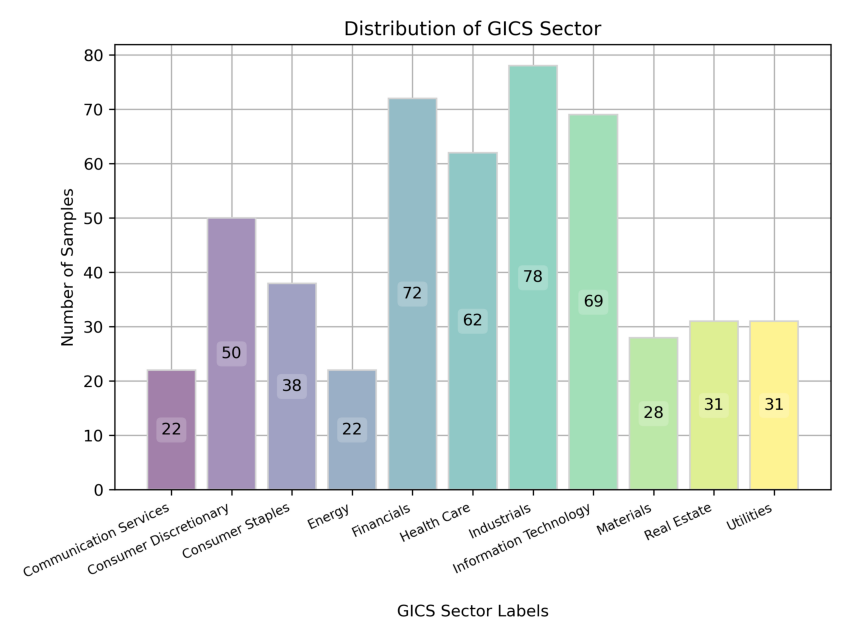

In [10]:
# Plot the Distribution for the GICS Sectors of all the Companies
plotFeatureDistribution(df=sp500Stocks, classFeature='GICS Sector', forceCategorical=False, pathsConfig=pathsConfig, featureDecoder=None)

In [11]:
# Extract a S&P-500 Stock Market Information
sp500MarketHistory = getSP500StockMarketInformation(config=config, pathsConfig=pathsConfig)

# Inpect the DataFrame
sp500MarketHistory.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily Return
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,3991400000,0.0,0.0,0.016043
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,2491020000,0.0,0.0,0.003116
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,4972660000,0.0,0.0,0.000546
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,5270680000,0.0,0.0,0.004001
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,4389590000,0.0,0.0,0.002882


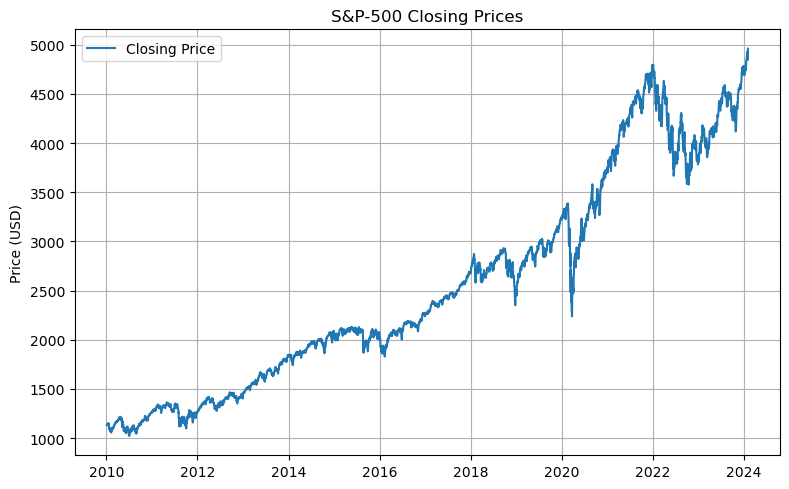

In [12]:
# Let's see a historical view of the closing price
plotStockClosingPrice(stockMarketHistory=sp500MarketHistory, title='S&P-500 Closing Prices')

In [13]:
# Extract the dates in which the market is open in January 2024 - Days in which we are going to perform inference
predictionDates = sp500MarketHistory[sp500MarketHistory['Date'] >= str(dt(2024, 1, 1).date())][sp500MarketHistory['Date'] < str(dt(2024, 2, 1).date())]['Date'].to_numpy()
predictionDates

array(['2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05',
       '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11',
       '2024-01-12', '2024-01-16', '2024-01-17', '2024-01-18',
       '2024-01-19', '2024-01-22', '2024-01-23', '2024-01-24',
       '2024-01-25', '2024-01-26', '2024-01-29', '2024-01-30',
       '2024-01-31'], dtype=object)

In [14]:
# Let's update the paths dictionary to include the paths in which to save the Extracted Data and Trained Models
pathsConfig = loadFinalPathsConfig(stocks=uniqueStocks, predictionDates=predictionDates)

---
### Feature Extraction and Creation
---

> ADD CONTENT TO HOW THE FEATURE EXTRACTION WAS PERFORMED WITH HELP OF THE YFINANCE APi

> MENTION ALL THE NEW METRICS CREATED TO BETTER DETERMINE THE VOLATILITY OF A STOCK

In [15]:
# EXAMPLE ON HOW TO EXTRACT A STOCK'S MARKET INFORMATION INTO A DATAFRAME

# Extract a Stock's Market Information
stockMarketHistory = getStockMarketInformation(stockSymbol='NVDA', config=config, pathsConfig=pathsConfig)
stockMarketHistory.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA,EMA,UpperBB,LowerBB,Daily_Return,Cumulative_Return,Window_Return,Volatility
0,2010-01-04,0.424410,0.426933,0.415239,0.423952,800204000,0.0,0.0,0.386383,0.388421,0.448433,0.324333,-0.010171,1.324499,0.336949,0.105565
1,2010-01-05,0.422347,0.434728,0.422347,0.430143,728648000,0.0,0.0,0.391542,0.392395,0.449835,0.333250,0.014602,1.343840,0.315568,0.102702
2,2010-01-06,0.429913,0.433811,0.425786,0.432894,649168000,0.0,0.0,0.394741,0.396252,0.454801,0.334681,0.006397,1.352436,0.173400,0.104711
3,2010-01-07,0.430601,0.432435,0.421200,0.424410,547792000,0.0,0.0,0.398409,0.398934,0.456148,0.340670,-0.019598,1.325931,0.209013,0.100835
4,2010-01-08,0.420971,0.428308,0.418449,0.425328,478168000,0.0,0.0,0.401688,0.401447,0.457603,0.345773,0.002161,1.328797,0.182282,0.101442


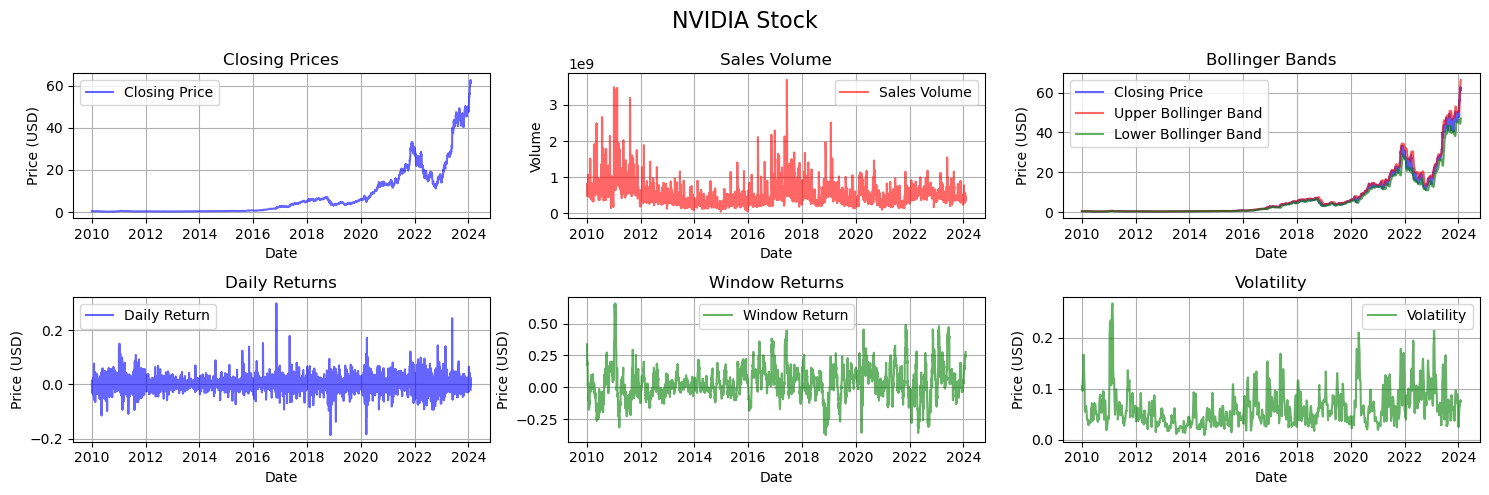

In [16]:
# Plotting the NVIDIA Statistics over the years
plotStockStats(stockMarketHistory=stockMarketHistory, title='NVIDIA Stock')

> EXEMPLIFY THE PIPELINE WITH A STOCK TO SHOWCASE WHAT IS HAPPENING

In [17]:
ds = stockPriceManager(stockSymbol='NVDA', feature='Close', windowSize=config['window'], predictionDate='2024-01-02', pathsConfig=pathsConfig)
x_train, y_train, x_test, y_test = ds.trainTestSplit()
# x_train.shape, y_train.shape
# x_test.shape, y_test.shape

In [18]:
# Create a instace of a Stock Price Predictor
nvdaPredictor = StockPricePredictor(stockSymbol="NVDA", datesToPredict=predictionDates, config=config, pathsConfig=pathsConfig)

In [41]:
# Train the selected models to perform inference
# nvdaPredictor.trainModels()

---

---

In [29]:
# x_train

In [19]:
# y_train.tail()

In [20]:
# x_test

In [21]:
# y_test

> SELECT ONLY A FEW OF THE STOCKS DUE TO THE OVERWHELMING AMOUNT TO TRAIN MODELS ON AND ALSO PERFORM PORTFOLIO OPTIMIZATION WITH

In [19]:
# Select the most important stocks per Industry Sector
selectedStocks = selectStocksToUse(worldWideStocks=worldWideStocks, sp500Stocks=sp500Stocks, numberStocks=5)
selectedStocks.head()

,Symbol,Name,Sector
0,GOOGL,Alphabet Inc. Class A Common Stock,Communication Services
1,GOOG,Alphabet Inc. Class C Capital Stock,Communication Services
2,META,Meta Platforms Inc. Class A Common Stock,Communication Services
3,FOXA,Fox Corporation Class A Common Stock,Communication Services
4,FOX,Fox Corporation Class B Common Stock,Communication Services


In [20]:
# Create a vector to store all the extracted stocks
extractedStocks = []

# Extract the market informations for all stocks
for symbol in selectedStocks.Symbol:
    X = getStockMarketInformation(stockSymbol=symbol, config=config, pathsConfig=pathsConfig)
    if X is None:
        pass
    else:
        # Update the extracted stocks list
        extractedStocks.append(symbol)

In [21]:
# Iterate through the extracted data
for symbol in extractedStocks:
    # Compute a windowed DataFrame to be later used to feed our models
    _ = stockPriceManager(stockSymbol=symbol, feature='Close', windowSize=config['window'], predictionDate='2024-01-01', pathsConfig=pathsConfig)
    # print(f"[{symbol}] Processed Successfully!")

In [40]:
# Create a instance of a StockPricePredictor for the current Stock
stockPredictor = StockPricePredictor(stockSymbol="AMZN", datesToPredict=predictionDates, config=config, pathsConfig=pathsConfig)

# Compute the models to predict the closing prices of each day in January 2024
stockPredictor.trainModels()

1/1 [==============================] - 0s 497ms/step
y_test = array([[151.94000244]])
y_pred_RandomForest = array([[154.64288685]])
y_pred_LGBM = array([[152.53527512]])
y_pred_XGBoost = array([[153.80382919]])
y_pred_LSTM = array([[153.77861]], dtype=float32)
1/1 [==============================] - 0s 482ms/step
y_test = array([[149.92999268]])
y_pred_RandomForest = array([[154.17447564]])
y_pred_LGBM = array([[151.75418717]])
y_pred_XGBoost = array([[151.92846001]])
y_pred_LSTM = array([[150.59404]], dtype=float32)
1/1 [==============================] - 0s 479ms/step
y_test = array([[148.47000122]])
y_pred_RandomForest = array([[151.24304294]])
y_pred_LGBM = array([[148.93358164]])
y_pred_XGBoost = array([[150.02098119]])
y_pred_LSTM = array([[150.24692]], dtype=float32)
1/1 [==============================] - 0s 493ms/step
y_test = array([[144.57000732]])
y_pred_RandomForest = array([[150.65624221]])
y_pred_LGBM = array([[149.18555521]])
y_pred_XGBoost = array([[149.29011441]])
y_pred

KeyboardInterrupt: 

In [22]:
# Iterate through the selected stocks
for stockSymbol in extractedStocks:
    print("\n[CURRENT STOCK]", stockSymbol)
    # Create a instance of a StockPricePredictor for the current Stock
    stockPredictor = StockPricePredictor(stockSymbol=stockSymbol, datesToPredict=predictionDates, config=config, pathsConfig=pathsConfig)

    # Compute the models to predict the closing prices of each day in January 2024
    stockPredictor.trainModels()


[CURRENT STOCK] GOOGL
Epoch 1/50
110/110 [==============================] - 16s 148ms/step - loss: 0.0064 - mean_absolute_error: 0.0355
Epoch 2/50
110/110 [==============================] - 17s 157ms/step - loss: 3.5638e-04 - mean_absolute_error: 0.0117
Epoch 3/50
110/110 [==============================] - 16s 149ms/step - loss: 3.5582e-04 - mean_absolute_error: 0.0116
Epoch 4/50
110/110 [==============================] - 16s 145ms/step - loss: 3.2994e-04 - mean_absolute_error: 0.0111
Epoch 5/50
110/110 [==============================] - 16s 144ms/step - loss: 3.1415e-04 - mean_absolute_error: 0.0112
Epoch 6/50
110/110 [==============================] - 16s 144ms/step - loss: 3.1512e-04 - mean_absolute_error: 0.0111
Epoch 7/50
110/110 [==============================] - 16s 145ms/step - loss: 3.0846e-04 - mean_absolute_error: 0.0110
Epoch 8/50
110/110 [==============================] - 16s 145ms/step - loss: 3.3731e-04 - mean_absolute_error: 0.0116
Epoch 9/50
110/110 [=================

KeyboardInterrupt: 

---
---

# IDEAS

Calcular o risco médio e selecionar as N (N=20) com a volatilidade mais proxima da da média

In [26]:
# Merge all the Closing Prices from all the stocks
stocksClosingPrices = mergeStocksClosingPrices(stocks=extractedStocks, pathsConfig=pathsConfig)
stocksClosingPrices.head()

,Date,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
0,2010-01-04,20.053036,6.447412,0.0,0.0,18.763716,7.601905,31.941803,37.090000,22.353195,...,52.549019,9.774272,41.184963,12.678838,39.272118,0.0,18.969753,52.354065,28.670000,0.0
1,2010-01-05,19.835205,6.458560,0.0,0.0,18.612118,7.576549,32.139191,37.700001,22.317911,...,52.431252,9.981768,43.689785,12.528471,39.425446,0.0,18.904886,54.011383,28.620001,0.0
2,2010-01-06,19.764725,6.355825,0.0,0.0,18.715479,7.543795,32.480862,37.619999,22.275558,...,53.275314,9.871396,43.116711,12.552533,39.766205,0.0,18.769733,53.993950,28.400000,0.0
3,2010-01-07,19.739100,6.344077,0.0,0.0,18.870523,7.499420,32.450493,36.889999,22.099108,...,53.118286,9.827247,44.037518,12.498397,39.641266,0.0,18.764336,55.232594,27.690001,0.0
4,2010-01-08,19.732689,6.386254,0.0,0.0,18.966997,7.484628,32.321423,36.689999,22.226145,...,53.059406,9.736745,43.721981,12.504414,39.482258,0.0,18.769733,54.072449,27.600000,0.0


---
---

---

<div align="center">

## ADD OTHER SECTIONS - PORTFOLIO OPTIMIZATION PROGRAM
</div>

---

<div align="center">
    
---
## Conclusions
---
</div>

> ADD CONCLUSIONS

<div align="center">

---
## Bibliographic References
---
</div>

1. AUTHOR (YEAR). __*TITLE*__. Available [here](_LINK_)

LINKS:
- https://medium.com/@kasperjuunge/yfinance-10-ways-to-analyze-stock-prices-18d2062ab35c

___
## Video Presentation (YouTube Video)

Moreover, you can find the **Video** for our **Project's Presentation [here](https://youtu.be/dQw4w9WgXcQ?si=M2fOqMOebz5GcYoj)**
___
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Francisco Macieira](https://github.com/franciscovmacieira) &#8594; `up202207166@edu.fc.up.pt`
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@edu.fc.up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@edu.fc.up.pt`

---
---
## Training TESTS

In [21]:
import pandas as pd
import numpy as np
from pytorch_forecasting import TimeSeriesDataSet, Informer, TemporalFusionTransformer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

# 1. Generate Synthetic Stock Price Data
# Simulate stock price data with a time series
np.random.seed(42)
data = {
    "time_idx": np.arange(1000),
    "value": np.sin(np.arange(1000) / 20) + np.random.normal(scale=0.5, size=1000),
    "group": "stock_1",  # Single stock for simplicity
}
df = pd.DataFrame(data)

# 2. Define the TimeSeriesDataSet
max_encoder_length = 30  # Number of past steps to look at
max_prediction_length = 10  # Number of future steps to predict

dataset = TimeSeriesDataSet(
    df,
    time_idx="time_idx",
    target="value",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["value"],
    target_normalizer=NaNLabelEncoder(),
)

# Create dataloaders for training and validation
train_dataloader = dataset.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = dataset.to_dataloader(train=False, batch_size=32, num_workers=0)

# 3. Define the Informer Model
model = Informer.from_dataset(
    dataset,
    learning_rate=1e-3,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.1,
    loss=QuantileLoss(),
    optimizer="adam",
    log_interval=10,  # Log metrics every 10 batches
)

# 4. Train the Model
trainer = Trainer(
    max_epochs=20,
    gradient_clip_val=0.1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3)],
    limit_train_batches=1.0,
)

trainer.fit(model, train_dataloader, val_dataloader)

# 5. Evaluate the Model
# Generate predictions on the validation dataset
predictions = model.predict(val_dataloader, return_y=True)

print("Predictions vs Actual:")
print(predictions)


OSError: [WinError 127] Impossível localizar o procedimento especificado. Error loading "C:\Users\Gongas\anaconda3\envs\SP500\lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

---
### LSTM
---

In [40]:
x_train

array([[0.0043902 , 0.00451355, 0.00456837, ..., 0.00354962, 0.00329379,
        0.00297401],
       [0.00451355, 0.00456837, 0.00439934, ..., 0.00329379, 0.00297401,
        0.00351307],
       [0.00456837, 0.00439934, 0.00441761, ..., 0.00297401, 0.00351307,
        0.00359074],
       ...,
       [0.95683727, 0.94845173, 0.95480566, ..., 0.98405273, 0.95431216,
        0.97182194],
       [0.94845173, 0.95480566, 0.92751762, ..., 0.95431216, 0.97182194,
        0.96863475],
       [0.95480566, 0.92751762, 0.92741805, ..., 0.97182194, 0.96863475,
        0.97757871]])

In [44]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau)

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mean_absolute_error'])

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=5e-4,
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=10,
    min_lr=1e-5
)

# Check the model architecture
model.summary()

# Train the model
# model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=100)
# model.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=[early_stopping, reduce_lr])
model.fit(x_train, y_train, batch_size=32, epochs=1000)

y_pred = model.predict(x_test)

y_pred[0][0], y_test[0]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 19, 128)           66560     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 25)                1625      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
110/110 [==============================] - 6s 18ms/step - loss: 34.3245 - mean_absolute_error: 2.0061
Epoch 2/1000
110/110 [==============================] - 2s 18ms/s

(49.038494, 49.511375427246094)

---
### Light Gradient Boosting Machine
---

In [23]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define the model
model = LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    verbose=-1
)

# Train with early stopping
model.fit(
    x_train, y_train,
    eval_metric='rmse',         # Metric for evaluation
)

# Get best iteration manually
best_iteration = model.best_iteration_

# Predict using the best iteration
y_pred = model.predict(x_test, num_iteration=best_iteration)

print(y_pred, y_test)

# Evaluate
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

[48.15735143] [49.51137543]
RMSE: 1.354023999831874


[47.68611079] [49.51137543]
RMSE: 1.825264640252641
MAE: 1.825264640252641


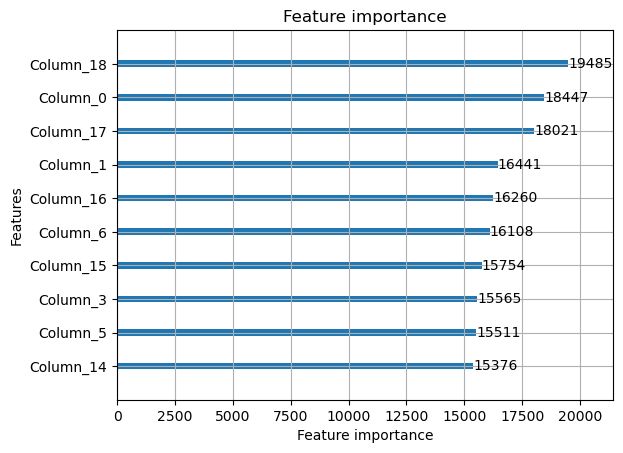

In [25]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Create LightGBM datasets
train_data = lgb.Dataset(x_train, label=y_train)

# Define parameters
params = {
    'objective': 'regression',       # Task: regression
    'metric': 'rmse',                # Evaluation metric: RMSE
    'boosting_type': 'gbdt',         # Gradient Boosted Decision Tree
    'num_leaves': 31,                # Max leaves per tree
    'learning_rate': 0.05,           # Learning rate
    'feature_fraction': 0.9,         # Fraction of features per iteration
    'bagging_fraction': 0.8,         # Fraction of data per iteration
    'bagging_freq': 5,               # Bagging frequency
    'verbose': -1                    # Suppress output
}

# Train the LightGBM model
model = lgb.train(
    params,
    train_data,
    num_boost_round=10000,            # Max boosting iterations
    # early_stopping_rounds=50,        # Stop if no improvement after 50 rounds
    # verbose_eval=10                  # Display progress every 10 iterations
)

# Make predictions on the validation set
y_pred = model.predict(x_test, num_iteration=model.best_iteration)

print(y_pred, y_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Plot feature importance
lgb.plot_importance(model, max_num_features=10)
plt.show()

---
### PROPHET BY FACEBOOK
---

In [41]:
import pandas as pd

# df = stockMarketHistory[['Date', 'Close']]
# df['ds'] = pd.to_datetime(df['Date'])
# df['y'] = df['Close']
# df=df.drop(columns=['Date', 'Close'])
# df.tail()

df = ds.prepareDataForProphet()
df.tail()

,ds,y
3517,2023-12-22,48.819527
3518,2023-12-26,49.268425
3519,2023-12-27,49.406395
3520,2023-12-28,49.511375
3521,2023-12-29,49.511375


14:01:22 - cmdstanpy - INFO - Chain [1] start processing
14:01:22 - cmdstanpy - INFO - Chain [1] done processing


[FUTURE DF]
              ds
0    2010-01-04
1    2010-01-05
2    2010-01-06
3    2010-01-07
4    2010-01-08
...         ...
3518 2023-12-26
3519 2023-12-27
3520 2023-12-28
3521 2023-12-29
3522 2023-12-30

[3523 rows x 1 columns]


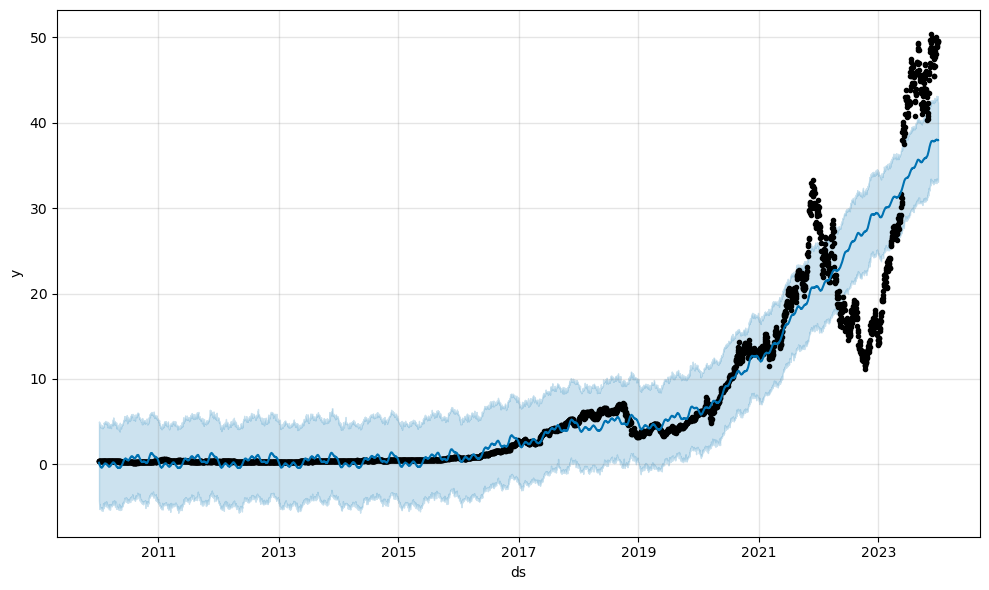

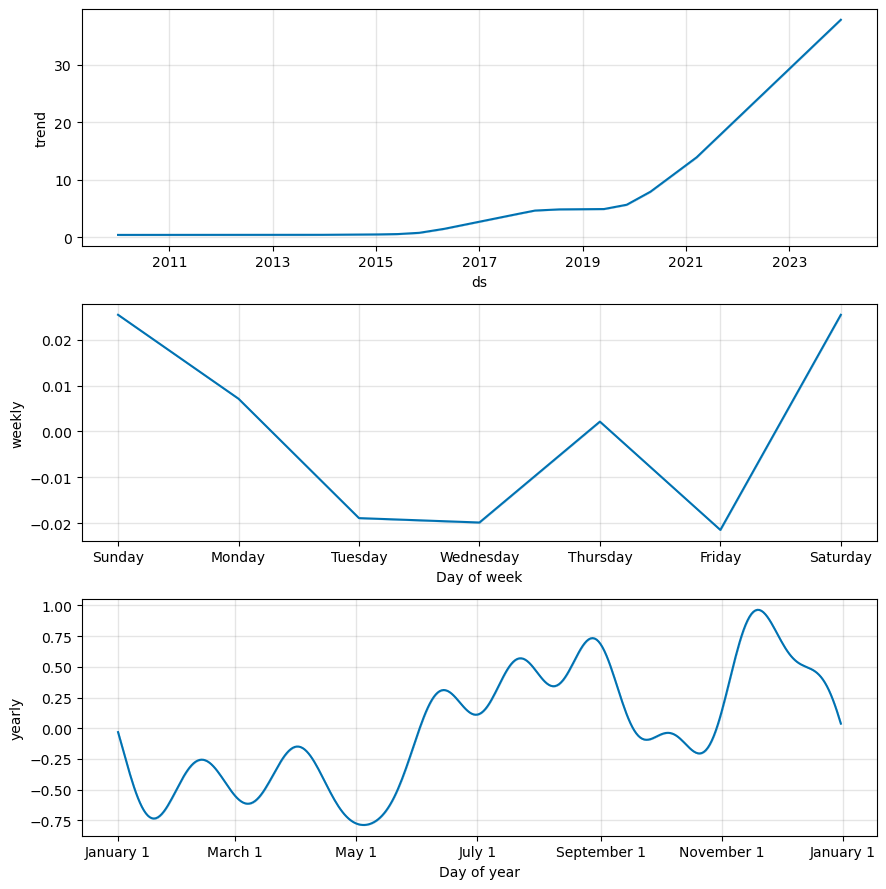

3521    49.511375
Name: y, dtype: float64
3522    37.949251
Name: yhat, dtype: float64
Mean Absolute Error: 11.562124645410478


In [42]:
from prophet import Prophet

# Initialize the Prophet model
model = Prophet()

# Fit the model to your data
model.fit(df)

daysToForecast = 1

# Create a DataFrame for future dates (e.g., next 7 days)
future = model.make_future_dataframe(periods=daysToForecast)  # Add 7 days to the forecast
print("[FUTURE DF]\n", future)  # View the new future dates

# Make predictions
forecast = model.predict(future)

import matplotlib.pyplot as plt

# Plot the forecast
model.plot(forecast)
plt.show()

# Plot the forecast components (trend, seasonality)
model.plot_components(forecast)
plt.show()

# print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

from sklearn.metrics import mean_absolute_error

# Subset actual and predicted values for validation
actual = df['y'].iloc[-daysToForecast:]
predicted = forecast['yhat'].iloc[-daysToForecast:]

print(actual)
print(predicted)

mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error: {mae}")

---
---

### ADDITIONAL TESTS - REGARDING OPTIMIZATION

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, risk_models, expected_returns

# Step 1: Fetch S&P 500 data
sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(sp500_url)[0]
tickers = sp500_table['Symbol'].tolist()
data = yf.download(tickers, start="2022-01-01", end="2024-01-01")['Adj Close']
data = data.dropna(axis=1)

# Step 2: Calculate returns and key metrics
returns = data.pct_change().dropna()
mean_returns = returns.mean() * 252
volatility = returns.std() * np.sqrt(252)
correlation_matrix = returns.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()

# Step 3: Select top stocks by Sharpe Ratio
risk_free_rate = 0
sharpe_ratios = (mean_returns - risk_free_rate) / volatility
top_stocks = sharpe_ratios.nlargest(10).index
selected_data = returns[top_stocks]

# Step 4: Portfolio Optimization
mu = expected_returns.mean_historical_return(data[top_stocks])
S = risk_models.sample_cov(data[top_stocks])
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

print("Optimized Weights:", cleaned_weights)
ef.portfolio_performance(verbose=True)

# Visualize portfolio allocation
plt.figure(figsize=(10, 6))
plt.bar(cleaned_weights.keys(), cleaned_weights.values())
plt.title("Portfolio Allocation")
plt.xlabel("Stocks")
plt.ylabel("Weights")
plt.show()

# Step 5: Backtest Portfolio
portfolio_returns = (selected_data * pd.Series(cleaned_weights)).sum(axis=1)
cumulative_returns = (1 + portfolio_returns).cumprod()

plt.figure(figsize=(10, 6))
cumulative_returns.plot()
plt.title("Cumulative Portfolio Returns")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.show()


ImportError: DLL load failed while importing clarabel: Impossível localizar o procedimento especificado.

---
---